# ロボットの移動ばらつきパラメータを求める

In [1]:
import sys
sys.path.append('../src')
import importlib

import drawables
import numpy as np
import particles

def reload():
    importlib.reload(drawables)
    importlib.reload(particles)

<IPython.core.display.Javascript object>


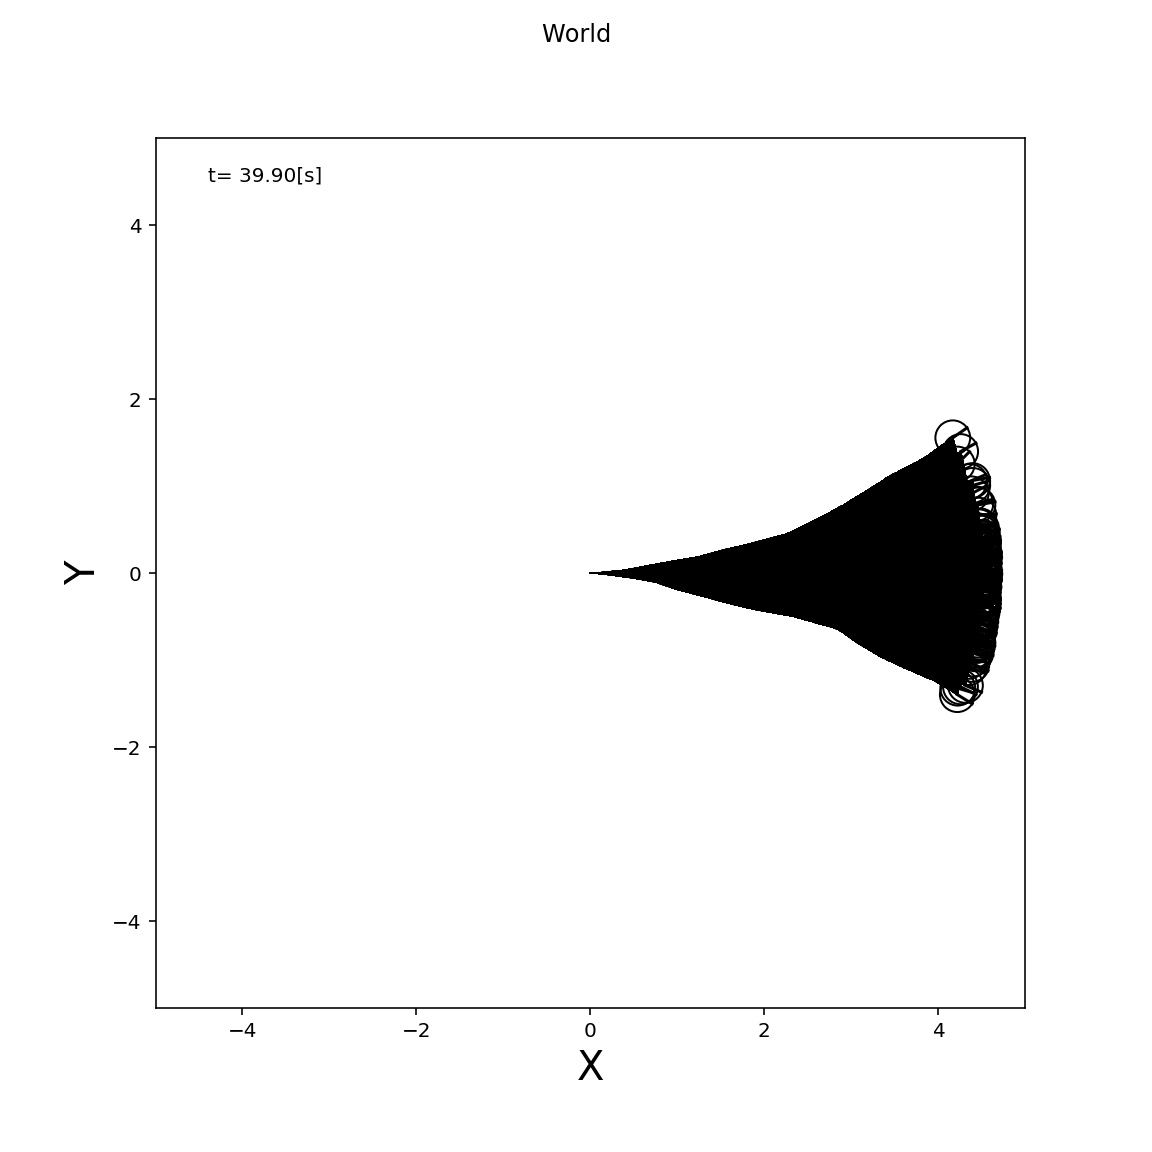

In [28]:
# ロボットを
# 0.1[m/s]で
# 4.0[m]走らせて
# 移動後の姿勢を記録する
# それを100回する
reload()

import copy

sim = drawables.Simulator(40., 0.1, debuggable=True)

initial_pose = np.array([0.,0.,0.])
agent = drawables.DrawableSimpleAgent(0.1, 0.0)
robot = drawables.DrawableRealRobot(initial_pose, agent=agent)
robots_ = []

for i in range(100):
    # 大本のロボットは使い回す
    # 道のりのばらつき以外のばらつきを統一するため
    copy_r = copy.copy(robot)
    copy_r.distance_until_noise = copy_r.noise_pdf.rvs()

    sim.append(copy_r)
    robots_.append(copy_r)
    
sim.draw()

In [29]:
# ↑の処理はめっちゃ時間かかかる
import math
import pandas as pd

# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,4.513734,4.541077,4.476945,4.524596,4.535348,4.512389,4.521813,4.501984,4.530382,4.518389,...,4.504270,4.410297,4.539038,4.538027,4.523037,4.514741,4.527508,4.462514,4.539723,4.539976
theta,0.262787,-0.072862,0.365618,-0.141661,0.147275,-0.397633,-0.262666,0.326630,0.114911,-0.122088,...,-0.409402,0.789142,0.051959,-0.087946,0.165402,0.123839,-0.105483,-0.515383,-0.056695,-0.003120


In [30]:
# 姿勢のばらつきと距離の平均から，直進が回転に与えるばらつきを求める

print(poses['theta'].var())
print(poses['r'].mean())

# 分散の大きさが距離に比例するなら (var / mean)^(1/2)が1[m]あたりの直進が回転に与える標準偏差になる
sigma_omega_nu = poses['theta'].var() / poses['r'].mean()
math.sqrt(sigma_omega_nu)

0.0589189059711229
4.520899601738623


0.11416024858672211

<IPython.core.display.Javascript object>


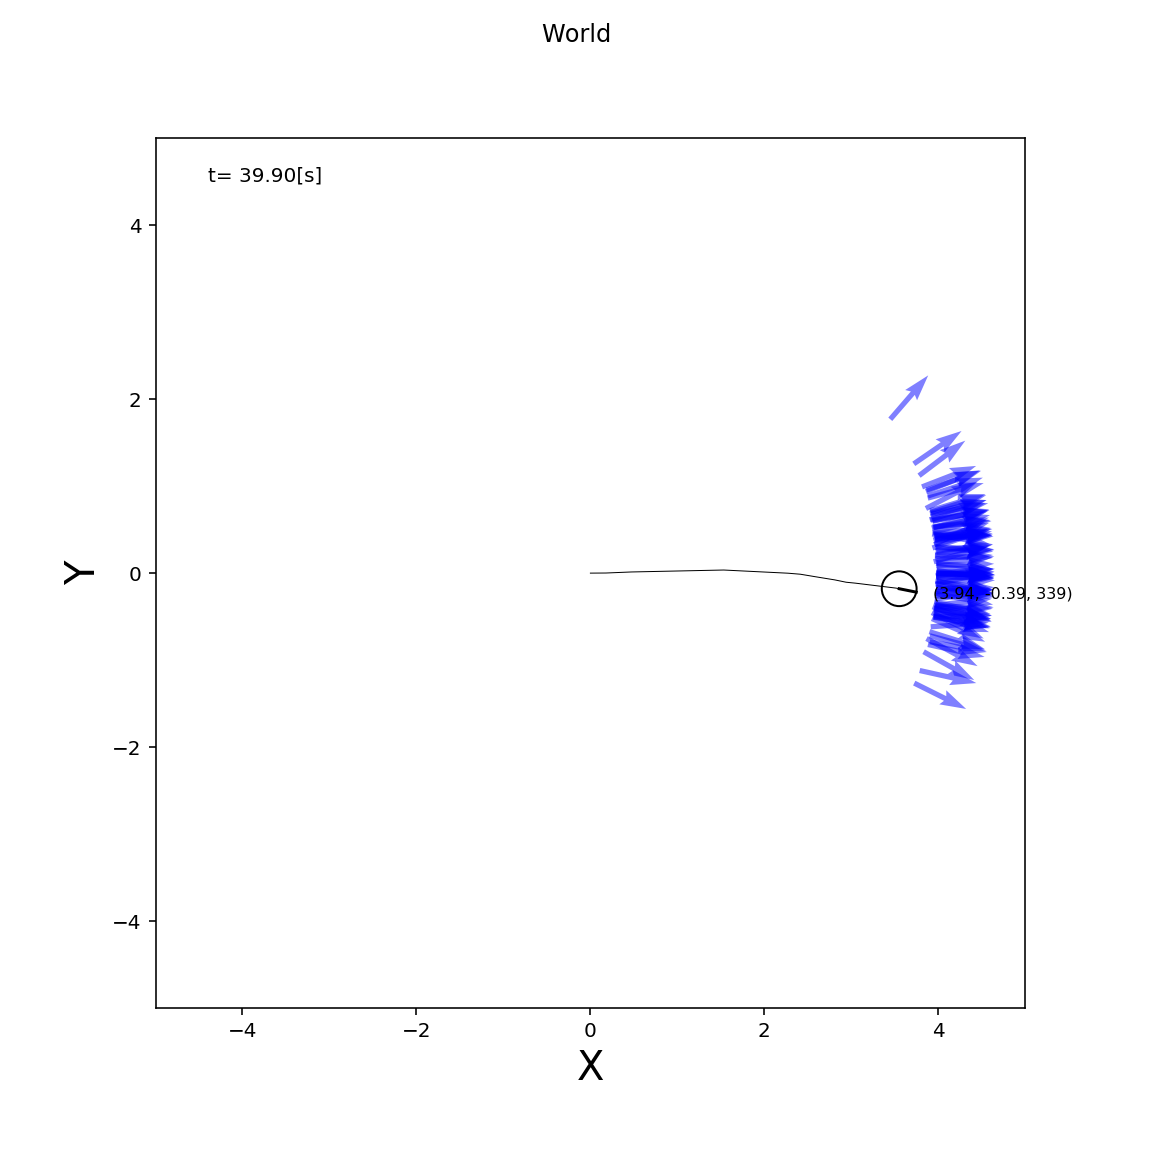

In [4]:
# 得られた値でパーティクルを動かしてみる
# さっきのロボット100台シミュレーションの結果と似ているのでは
reload()
sim = drawables.Simulator(40., 0.1, debuggable=False)

# on以外は小さな値にしておく
init_pose = np.array([0., 0., 0.])
particle_num = 100
init_weight = 1. / particle_num
particle = particles.SimpleParticle(init_pose, init_weight)
robot = drawables.DrawableRealRobot(
    np.array([0.,0.,0.]),
    sensor=None,
    agent=drawables.DrawableEstimationAgent(
        0.1, 0.1, 0.,
        estimator=drawables.DrawableMcl(
            drawables.DrawableMap(),
            np.array([0., 0., 0.]),
            [particle for i in range(100)],
            motion_noise_stds={
                'nn':0.001, 'no': 0.001, 'on': 0.127, 'oo': 0.001
            })))

sim.append(robot)    
sim.draw()

<IPython.core.display.Javascript object>


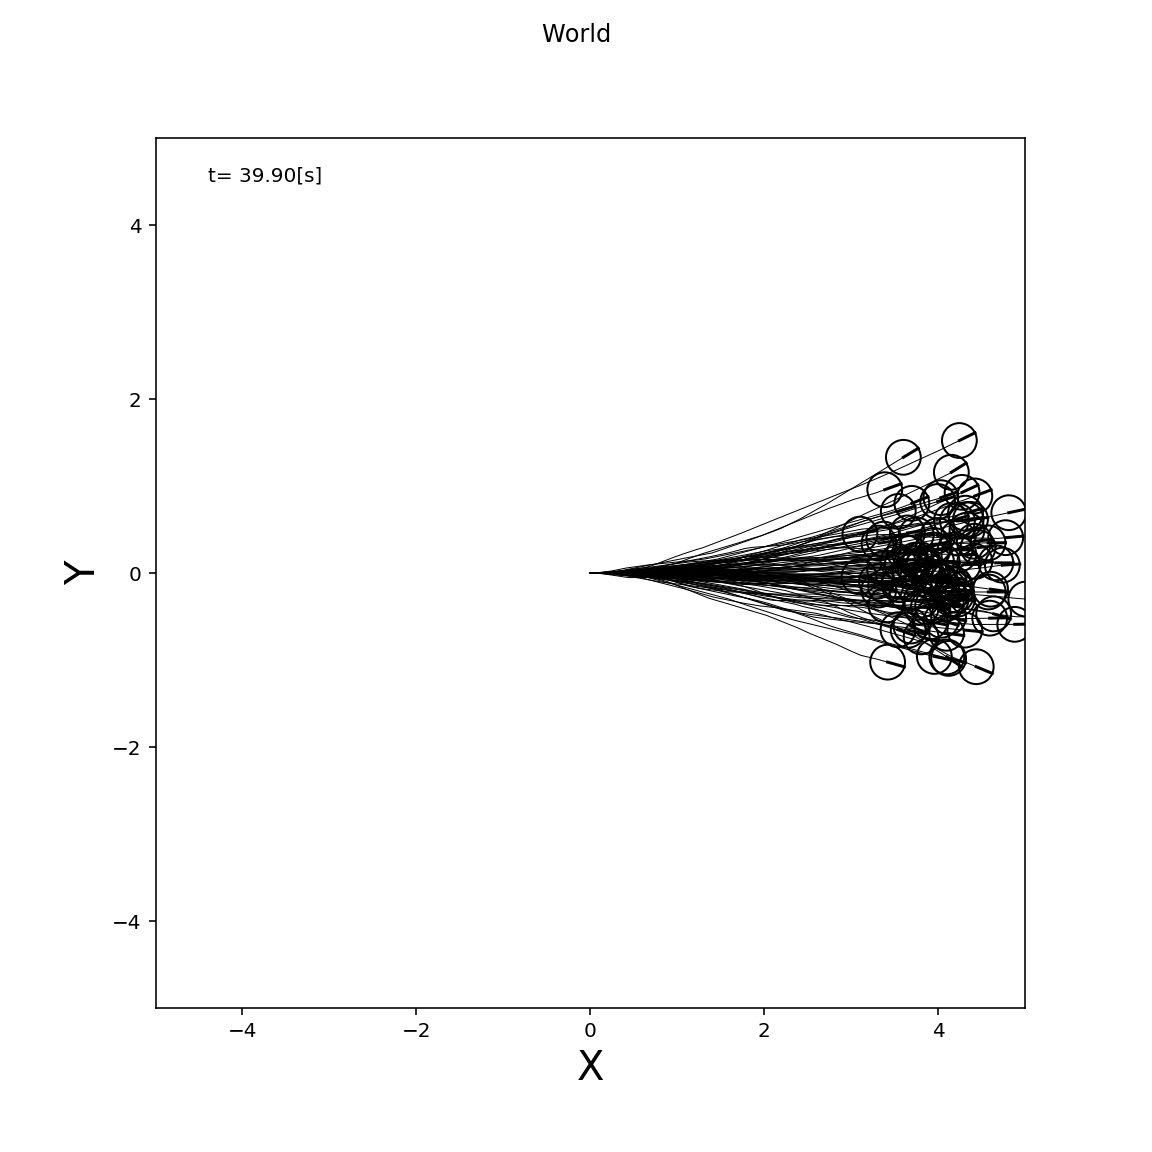

In [5]:
# 次はバイアスの影響を正規分布に当てはめる
reload()
sim = drawables.Simulator(40., 0.1, debuggable=True)

initial_pose = np.array([0.,0.,0.])


robots_ = []

for i in range(100):
    robot = drawables.DrawableRealRobot(
        initial_pose, sensor=None, agent=drawables.DrawableSimpleAgent(0.1, 0.0))
    sim.append(robot)
    robots_.append(robot)
    
sim.draw()

In [19]:
# 距離rと姿勢theta
import pandas as pd
import math
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,4.738308,4.039146,3.685076,3.447823,3.645784,4.367754,4.395611,4.122840,4.679544,4.279604,...,3.894754,3.522151,4.444116,3.865280,4.467692,4.446893,4.482432,3.732921,4.425047,5.000321
theta,0.197940,0.016104,0.031758,-0.171688,0.090882,-0.211669,-0.285208,0.236419,-0.426596,-0.177328,...,-0.155470,-0.188707,0.148974,-0.060301,0.168583,-0.240112,0.226721,-0.093906,0.675138,0.152265


In [20]:
# 直進が直進に与えるばらつきの標準偏差
r_mean = poses['r'].mean()
r_var = poses['r'].var()
sigma_nu_nu = math.sqrt(r_var / r_mean)
print(sigma_nu_nu)

0.1950571035326515


<IPython.core.display.Javascript object>


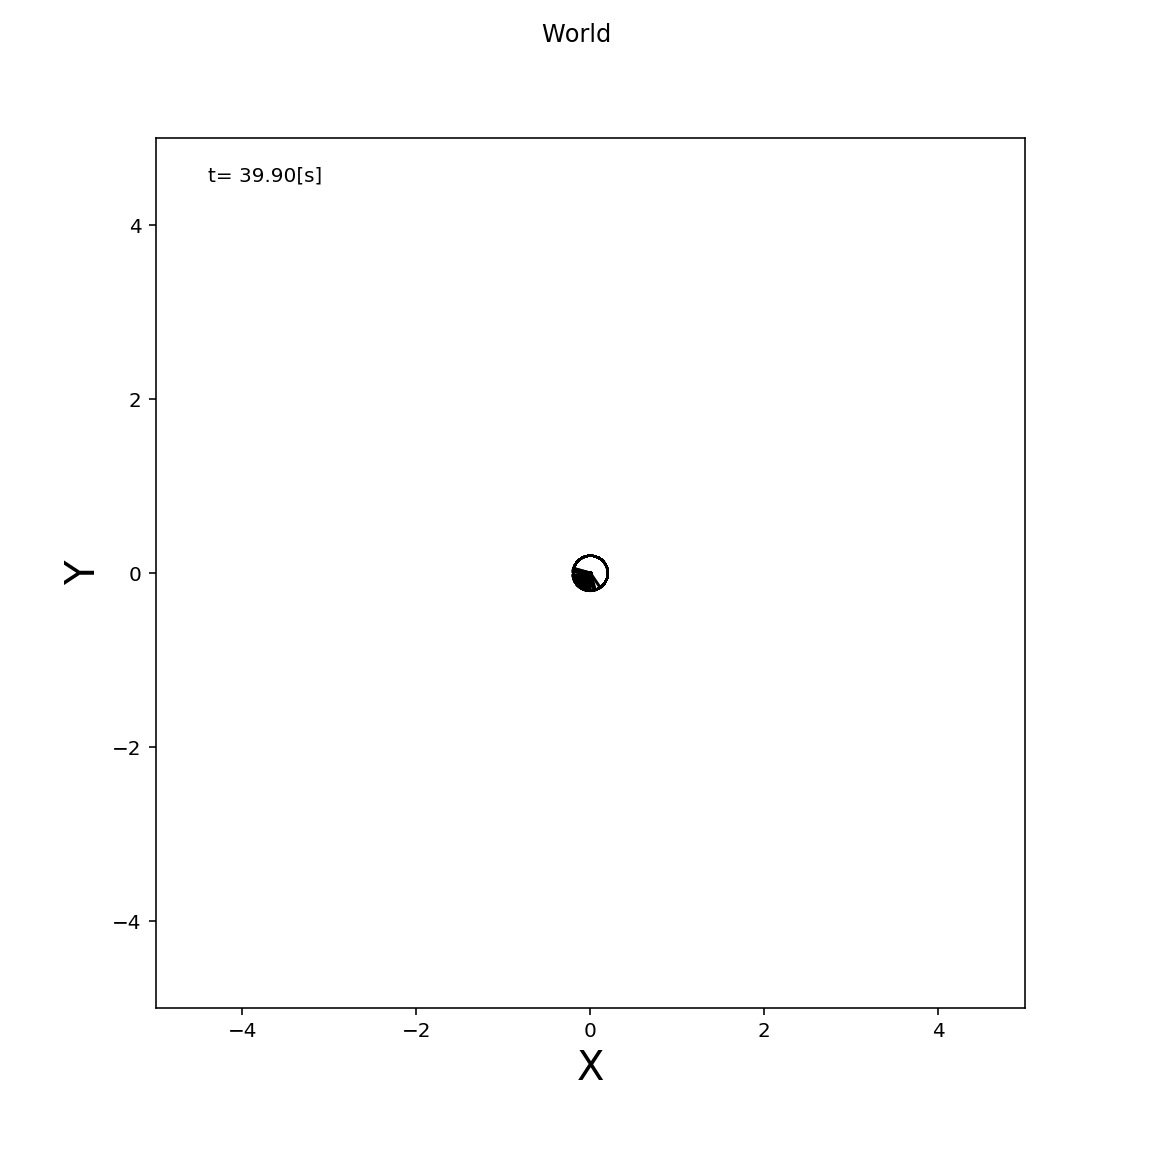

In [6]:
# 回転が回転にあたえるばらつきを求める
sim = drawables.Simulator(40.0, 0.1)  

initial_pose = np.array([0, 0, 0]).T
robots_ = []

for i in range(100):
    # 回転のみに指令が当たられたAgent
    r = drawables.DrawableRealRobot(initial_pose, sensor=None, agent=drawables.DrawableSimpleAgent(0.0, 0.1)) 
    sim.append(r)
    robots_.append(r)

sim.draw()

In [22]:
# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

# 回転が回転にあたえるばらつきの標準偏差
theta_mean = poses['theta'].mean()
theta_var = poses['theta'].var()
sigma_omega_omega = math.sqrt(theta_var / theta_mean)
print(sigma_omega_omega)

0.21763344457655187


<IPython.core.display.Javascript object>


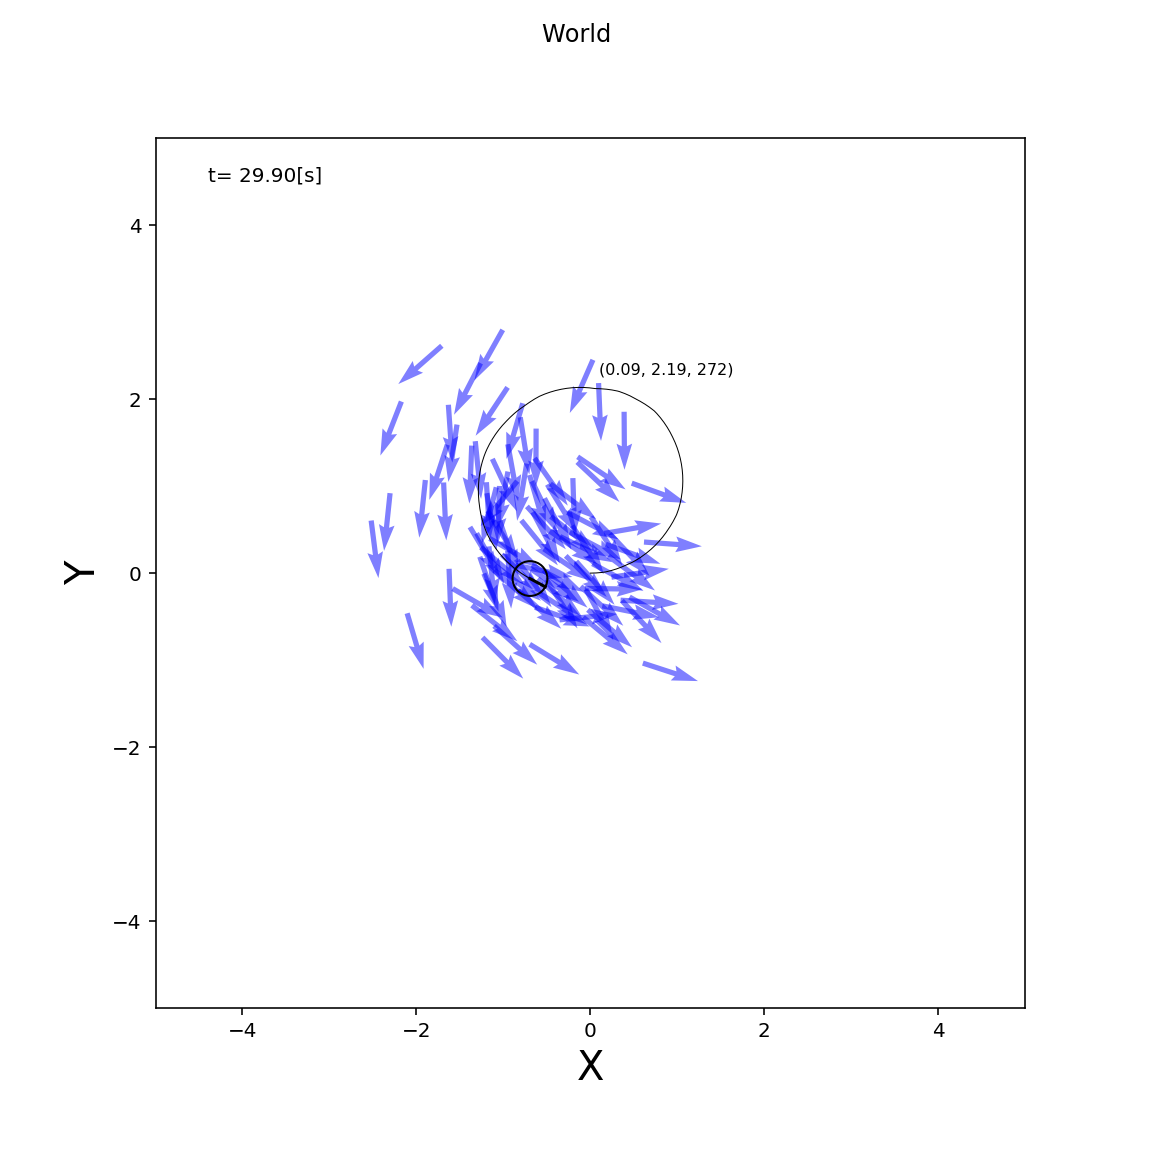

In [8]:
# このパラメータを使ってパーティクルを動かす
reload()
sim = drawables.Simulator(30., 0.1, debuggable=False)
m = drawables.DrawableMap()
initial_pose = np.array([0.,0.,0.])
# on以外は小さな値にしておく
estimator = drawables.DrawableMcl(
    m,
    initial_pose,
    [particles.SimpleParticle(initial_pose, 0.01) for i in range(100)])
circling = drawables.DrawableEstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)

robot = drawables.DrawableRealRobot(initial_pose, sensor=None, agent=circling)
sim.append(robot)
    
sim.draw()

## まとめ

- $\sigma_{\nu \nu} = 0.253$
- $\sigma_{\nu \omega} = 0$
- $\sigma_{\omega \nu} = 0.115$
- $\sigma_{\omega \omega} = 0.226$

$\sigma_{\nu \omega} = 0$なのは，回転が直進へ与えるノイズを設定していないため